# Robustness to Image Distortion - CNN Malaria

Dataset is downloaded from https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria/

## LIBRARIES

In [1]:
import numpy as np
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
from tensorflow import keras
import PIL
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import np_utils
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import tensorflow as tf
import shutil
import imageio
from datetime import datetime as dt
import random
from os import listdir,makedirs
from os.path import isfile,join
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
%matplotlib inline
import itertools
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance, ImageStat

Using TensorFlow backend.


## DATA VISUALIZATION

Inspired by https://www.kaggle.com/harshel7/detecting-malaria-val-accuracy-97

In [2]:
parasitized_data = os.listdir(r'cell_images/cell_images/Parasitized/')
uninfected_data = os.listdir(r'cell_images/cell_images/Uninfected/')

### PARASITIZED DATA

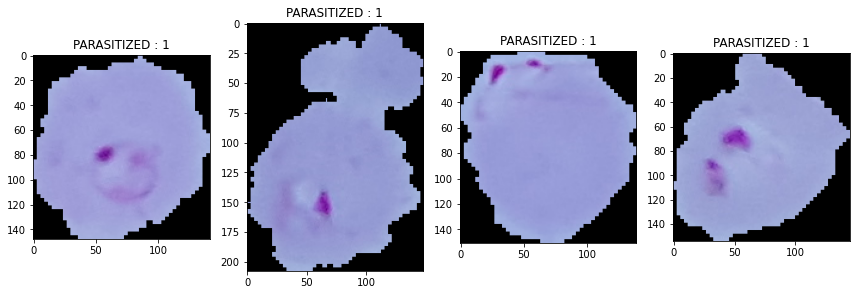

In [3]:
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread('cell_images/cell_images/Parasitized' + "/" + parasitized_data[i])
    plt.imshow(img)
    plt.title('PARASITIZED : 1')
    plt.tight_layout()
plt.show()

### UNINFECTED DATA

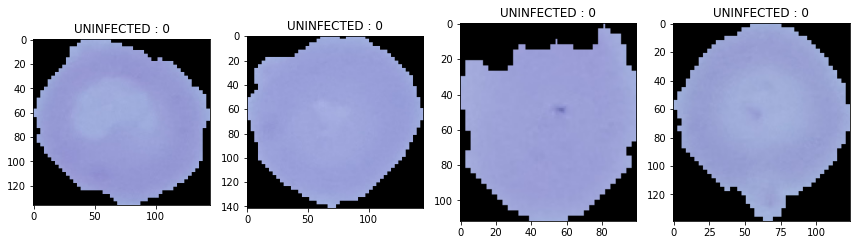

In [4]:
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(r'cell_images/cell_images/Uninfected' + "/" + uninfected_data[i+1])
    plt.imshow(img)
    plt.title('UNINFECTED : 0')
    plt.tight_layout()
plt.show()

## DATA PREPARATION

Inspired by https://github.com/saugatapaul1010/Malaria-Detection-using-Deep-Neural-Nets

### UTILITY FUNCTIONS

In [5]:
def resize_image(image):
    resized_image = cv2.resize(image, (50,50), interpolation = cv2.INTER_AREA) #Resize all the images to 128X128 dimensions
    return resized_image

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### CREATE FOLDERS

Here, we will create the folders 'train', 'validation, and 'test', which we will use to train, validate and test our models performance on unseen data.

In [7]:
source = 'cell_images'
destination = 'data'

#We will check if the folder 'data','train','test','validation' exists. If its not, we will create a folder with the same name
os.mkdir(destination) if not os.path.isdir(destination) else None
os.mkdir(destination+"/train") if not os.path.isdir(destination+"/train") else None
os.mkdir(destination+"/validation") if not os.path.isdir(destination+"/validation") else None
os.mkdir(destination+"/test") if not os.path.isdir(destination+"/test") else None

#We will check if the folder 'Parasitized' and 'Uninfected' exists. If its not, we will create a folder with the same name
os.mkdir(destination+"/train"+"/Parasitized") if not os.path.isdir(destination+"/train"+"/Parasitized") else None
os.mkdir(destination+"/train"+"/Uninfected") if not os.path.isdir(destination+"/train"+"/Uninfected") else None

os.mkdir(destination+"/validation"+"/Parasitized") if not os.path.isdir(destination+"/validation"+"/Parasitized") else None
os.mkdir(destination+"/validation"+"/Uninfected") if not os.path.isdir(destination+"/validation"+"/Uninfected") else None

os.mkdir(destination+"/test"+"/Parasitized") if not os.path.isdir(destination+"/test"+"/Parasitized") else None
os.mkdir(destination+"/test"+"/Uninfected") if not os.path.isdir(destination+"/test"+"/Uninfected") else None

In [8]:
#Get all the filenames from the original "cell_images" data folder
par_filenames=os.listdir(source+"/Parasitized")
un_filenames=os.listdir(source+"/Uninfected")

#Get details about the number of images present
print("Number of images of type 'Parasitized': ",len(par_filenames))
print("Number of images of type 'Uninfected': ",len(un_filenames))

Number of images of type 'Parasitized':  13779
Number of images of type 'Uninfected':  13779


### SPLIT DATA

We will split these images into train, test and cross validation dataset. We will randomly take 80% of images for training, 10% of the training images for validation and 20% of all images for evaluating the models performance on unseen data. With this idea in mind let's split our actual dataset into three folders mentioned above. Specific: training on 19840 images, validating on 2204 images and testing on 5514 images.

In [9]:
st=dt.now()

#First, the Parasitized images
par_train_images=random.sample(par_filenames,9920)
par_val_images=random.sample(list(set(par_filenames)-set(par_train_images)),1102)
par_test_images=list(set(par_filenames)-set(par_train_images)-set(par_val_images))

for file in par_train_images:
    if (file.endswith("png")):
        image=imageio.imread(source+"/Parasitized"+"/"+file)
        resized_image=resize_image(image)
        imageio.imsave(destination+"/train"+"/Parasitized/"+file,resized_image)
print("Train folder created for Parasitized images...")
        
for file in par_val_images:
    if (file.endswith("png")):
        image=imageio.imread(source+"/Parasitized"+"/"+file)
        resized_image=resize_image(image)
        imageio.imsave(destination+"/validation"+"/Parasitized/"+file,resized_image)
print("Validation folder created for Parasitized images...")
        
for file in par_test_images:
    if (file.endswith("png")):
        image=imageio.imread(source+"/Parasitized"+"/"+file)
        resized_image=resize_image(image)
        imageio.imsave(destination+"/test"+"/Parasitized/"+file,resized_image)
print("Test folder created for Parasitized images...")
        
#Now, the uninfected files
un_train_images=random.sample(un_filenames,9920)
un_val_images=random.sample(list(set(un_filenames)-set(un_train_images)),1102)
un_test_images=list(set(un_filenames)-set(un_train_images)-set(un_val_images))

for file in un_train_images:
    if (file.endswith("png")):
        image=imageio.imread(source+"/Uninfected"+"/"+file)
        resized_image=resize_image(image)
        imageio.imsave(destination+"/train"+"/Uninfected/"+file,resized_image)
print("Train folder created for Uninfected images...")

for file in un_val_images:
    if (file.endswith("png")):
        image=imageio.imread(source+"/Uninfected"+"/"+file)
        resized_image=resize_image(image)
        imageio.imsave(destination+"/validation"+"/Uninfected/"+file,resized_image)
print("Validation folder created for Uninfected images...")
    
for file in un_test_images:
    if (file.endswith("png")):
        image=imageio.imread(source+"/Uninfected"+"/"+file)
        resized_image=resize_image(image)
        imageio.imsave(destination+"/test"+"/Uninfected/"+file,resized_image)  
print("Test folder created for Uninfected images...")
        
print("\nTotal time taken to resize the images and create the dataset: ",dt.now()-st)

Train folder created for Parasitized images...
Validation folder created for Parasitized images...
Test folder created for Parasitized images...
Train folder created for Uninfected images...
Validation folder created for Uninfected images...
Test folder created for Uninfected images...

Total time taken to resize the images and create the dataset:  0:05:32.701390


## DATA PREPROCESSING

Inspired by https://www.kaggle.com/harshel7/detecting-malaria-val-accuracy-97

In [3]:
# train directory
train_parasitized_data = os.listdir('data/train/Parasitized/')
train_uninfected_data = os.listdir('data/train/Uninfected/')

# validation directory
val_parasitized_data = os.listdir('data/validation/Parasitized/')
val_uninfected_data = os.listdir('data/validation/Uninfected/')

# test directory
test_parasitized_data = os.listdir('data/test/Parasitized/')
test_uninfected_data = os.listdir('data/test/Uninfected/')

### TRAIN

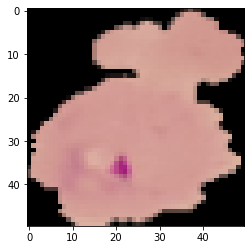

In [4]:
train_data = []
train_labels = []

for img in train_parasitized_data:
    try:
        img_read = plt.imread('data/train/Parasitized/' + "/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        train_data.append(img_array)
        train_labels.append(1)
    except:
        None
        
for img in train_uninfected_data:
    try:
        img_read = plt.imread('data/train/Uninfected' + "/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        train_data.append(img_array)
        train_labels.append(0)
    except:
        None
        
x_train = np.array(train_data)
y_train = np.array(train_labels)
y_train = np_utils.to_categorical(y_train, num_classes = 2)
        
plt.imshow(train_data[0])
plt.show()

### VALIDATION

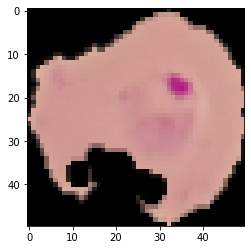

In [5]:
val_data = []
val_labels = []

for img in val_parasitized_data:
    try:
        img_read = plt.imread('data/validation/Parasitized/' + "/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        val_data.append(img_array)
        val_labels.append(1)
    except:
        None
        
for img in val_uninfected_data:
    try:
        img_read = plt.imread('data/validation/Uninfected' + "/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        val_data.append(img_array)
        val_labels.append(0)
    except:
        None
        
x_val = np.array(val_data)
y_val = np.array(val_labels)
y_val = np_utils.to_categorical(y_val, num_classes = 2)
        
plt.imshow(val_data[0])
plt.show()

### TEST

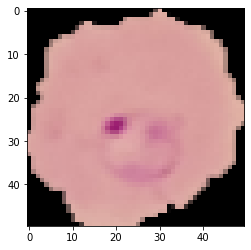

In [6]:
test_data = []
test_labels = []

for img in test_parasitized_data:
    try:
        img_read = plt.imread('data/test/Parasitized/' + "/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        test_data.append(img_array)
        test_labels.append(1)
    except:
        None
        
for img in test_uninfected_data:
    try:
        img_read = plt.imread('data/test/Uninfected' + "/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        test_data.append(img_array)
        test_labels.append(0)
    except:
        None
        
x_test = np.array(test_data)
y_test = np.array(test_labels)
y_test = np_utils.to_categorical(y_test, num_classes = 2)
        
plt.imshow(test_data[0])
plt.show()

### SHOW RESULTS

In [9]:
print(f'SHAPE OF TRAINING IMAGE DATA : {x_train.shape}')
print(f'SHAPE OF VALIDATION IMAGE DATA : {x_val.shape}')
print(f'SHAPE OF TESTING IMAGE DATA : {x_test.shape}')

print(f'SHAPE OF TRAINING LABELS : {y_train.shape}')
print(f'SHAPE OF VALIDATION LABELS : {y_val.shape}')
print(f'SHAPE OF TESTING LABELS : {y_test.shape}')

SHAPE OF TRAINING IMAGE DATA : (19840, 50, 50, 3)
SHAPE OF VALIDATION IMAGE DATA : (2204, 50, 50, 3)
SHAPE OF TESTING IMAGE DATA : (5514, 50, 50, 3)
SHAPE OF TRAINING LABELS : (19840, 2)
SHAPE OF VALIDATION LABELS : (2204, 2)
SHAPE OF TESTING LABELS : (5514, 2)


## BUILDING THE MODEL

Inspired by https://www.kaggle.com/harshel7/detecting-malaria-val-accuracy-97

According to Kumar, A., Sarkar, S., & Pradhan, C. (2020). Malaria Disease Detection Using CNN Technique with SGD, RMSprop and ADAM Optimizers. In Deep Learning Techniques for Biomedical and Health Informatics (pp. 211-230). Springer, Cham.

## DEFINE MODEL

In [16]:
def CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(16, (2,2), activation = 'relu', padding='same', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(32, (2,2), padding='same', activation = 'relu'))
    model.add(MaxPooling2D(2,2))


    model.add(Conv2D(64, (2,2), padding='same', activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

### INSTANTIATE MODEL

In [17]:
height = 50
width = 50
classes = 2
channels = 3
model = CNNbuild(height = height, width = width, classes = classes, channels = channels)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 16)        208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0

### COMPILE MODEL

In [18]:
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

### CALLBACKS

In [19]:
# early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1, mode='min')

In [20]:
# model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

### TRAIN MODEL

In [21]:
#fit the model onto the dataset
h = model.fit(x_train, y_train, validation_data = (x_val, y_val),  epochs = 20, batch_size = 32, callbacks=[es, mc])

Epoch 1/20
620/620 [==============================] - ETA: 0s - loss: 0.4129 - accuracy: 0.8045
Epoch 00001: val_loss improved from inf to 0.15502, saving model to best_model.h5
620/620 [==============================] - 67s 108ms/step - loss: 0.4129 - accuracy: 0.8045 - val_loss: 0.1550 - val_accuracy: 0.9505
Epoch 2/20
620/620 [==============================] - ETA: 0s - loss: 0.1651 - accuracy: 0.9487
Epoch 00002: val_loss improved from 0.15502 to 0.15194, saving model to best_model.h5
620/620 [==============================] - 71s 115ms/step - loss: 0.1651 - accuracy: 0.9487 - val_loss: 0.1519 - val_accuracy: 0.9510
Epoch 3/20
620/620 [==============================] - ETA: 0s - loss: 0.1460 - accuracy: 0.9535
Epoch 00003: val_loss improved from 0.15194 to 0.12960, saving model to best_model.h5
620/620 [==============================] - 66s 107ms/step - loss: 0.1460 - accuracy: 0.9535 - val_loss: 0.1296 - val_accuracy: 0.9560
Epoch 4/20
620/620 [==============================] - ET

In [7]:
# save best model
saved_model = load_model('best_model.h5')

In [8]:
#evaluate the model on train data
train_predictions = saved_model.evaluate(x_train, y_train)
#evaluate the model on validation data
validation_predictions = saved_model.evaluate(x_val, y_val)
#evaluate the model on test data
test_predictions = saved_model.evaluate(x_test, y_test)

173/173 [==============================] - 3s 15ms/step - loss: 0.1296 - accuracy: 0.9577


In [9]:
print(f'TRAIN ACCURACY : {train_predictions[1]}')
print(f'VALIDATION ACCURACY : {validation_predictions[1]}')
print(f'TEST ACCURACY : {test_predictions[1]}')

TRAIN ACCURACY : 0.9720262289047241
VALIDATION ACCURACY : 0.9573502540588379
TEST ACCURACY : 0.9577439427375793


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Confusion matrix, without normalization
[[2673   84]
 [ 149 2608]]


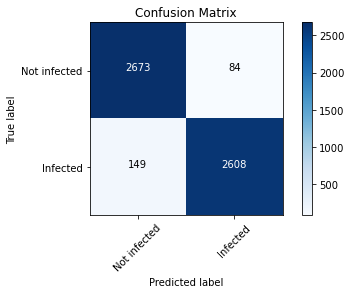

In [10]:
rounded_labels=np.argmax(y_test, axis=1)
prediction = saved_model.predict_classes(x_test)
cm = confusion_matrix(rounded_labels, prediction)
cm_plot_labels = ["Not infected", "Infected"]
plot_confusion_matrix(cm, cm_plot_labels, title="Confusion Matrix")

In [11]:
target_names = ['Uninfected', 'Parasitized']
print(classification_report(rounded_labels, prediction, target_names=target_names))

              precision    recall  f1-score   support

  Uninfected       0.95      0.97      0.96      2757
 Parasitized       0.97      0.95      0.96      2757

    accuracy                           0.96      5514
   macro avg       0.96      0.96      0.96      5514
weighted avg       0.96      0.96      0.96      5514



## DISTORTION OF TEST IMAGES

Inspired by Dodge, S., & Karam, L. (2016, June). Understanding how image quality affects deep neural networks. In 2016 eighth international conference on quality of multimedia experience (QoMEX) (pp. 1-6). IEEE.

### BLUR

Inspired by https://www.programcreek.com/python/example/86807/cv2.GaussianBlur

In [39]:
blur_dict = {"0":test_predictions[1]}
blur_images = [test_data[0]]


for i in range(1,10):
    k = int(np.ceil(4 * i + 0.5))

    path = r'data\test\Uninfected' # Source Folder
    dstpath_uninfected = r'Blur\Uninfected' + "_sigma_" + str(i) # Destination Folder

    try:
        makedirs(dstpath_uninfected)
    except:
        print("Directory already exist, images will be written in asme folder")

    # Folder won't used
    files = [f for f in listdir(path) if isfile(join(path,f))] 

    for image in files:
        try:
            src = cv2.imread(os.path.join(path,image), cv2.IMREAD_UNCHANGED)
            dst = cv2.GaussianBlur(src,(k,k),borderType=cv2.BORDER_DEFAULT, sigmaX=i)
            dstPath = join(dstpath_uninfected,image)
            cv2.imwrite(dstPath, dst) 
        except:
            print ("{} is not converted".format(image))
            
            
    
    path = r'data\test\Parasitized' # Source Folder
    dstpath_infected = r'Blur\Parasitized' + "_sigma_" + str(i) # Destination Folder

    try:
        makedirs(dstpath_infected)
    except:
        print("Directory already exist, images will be written in asme folder")

    # Folder won't used
    files = [f for f in listdir(path) if isfile(join(path,f))] 

    for image in files:
        try:
            src = cv2.imread(os.path.join(path,image), cv2.IMREAD_UNCHANGED)
            dst = cv2.GaussianBlur(src,(k,k),borderType=cv2.BORDER_DEFAULT, sigmaX=i)
            dstPath = join(dstpath_infected,image)
            cv2.imwrite(dstPath, dst) 
        except:
            print ("{} is not converted".format(image))
            
            
            
    blur_parasitized_data = os.listdir(dstpath_infected)
    blur_uninfected_data = os.listdir(dstpath_uninfected)
    
    
    
    
    blur_test_data = []
    blur_test_labels = []

    for img in blur_parasitized_data:
        try:
            img_read = plt.imread('Blur/Parasitized' + "_sigma_" + str(i) + "/" + img)
            img_array = img_to_array(img_read)
            blur_test_data.append(img_array)
            blur_test_labels.append(1)
        except:
            None

    for img in blur_uninfected_data:
        try:
            img_read = plt.imread('Blur/Uninfected' + "_sigma_" + str(i) + "/" + img)
            img_array = img_to_array(img_read)
            blur_test_data.append(img_array)
            blur_test_labels.append(0)
        except:
            None
            
            
    # test
    blur_test_data = np.array(blur_test_data)
    blur_test_labels = np.array(blur_test_labels)
    
    blur_labels = np_utils.to_categorical(blur_test_labels, num_classes = 2)
    
    #evaluate the model on test data
    blur_predictions = saved_model.evaluate(blur_test_data, blur_labels)
    
    blur_dict[str(i)] = blur_predictions[1]
    
    blur_images.append(blur_test_data[0])
    
    

173/173 [==============================] - 4s 24ms/step - loss: 1.0583 - accuracy: 0.5127


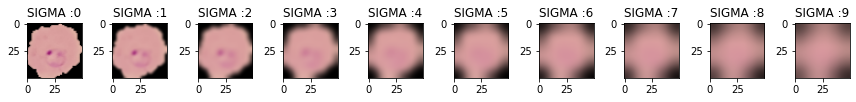

In [40]:
plt.figure(figsize = (12,12))
for i in range(len(blur_images)):
    plt.subplot(1, len(blur_images), i+1)
    img = blur_images[i]
    plt.imshow(img)
    plt.title('σ : ' + str(0+i))
    plt.tight_layout()
plt.show()

Text(0, 0.5, 'Accuracy')

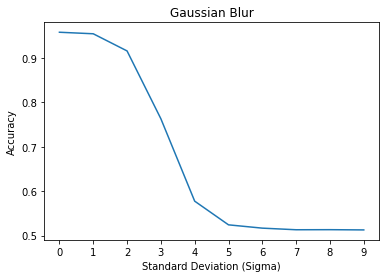

In [42]:
blur_list = []
for i in blur_dict:
    blur_list.append(i)
    
blur_list_values = []
for i in blur_dict.values():
    blur_list_values.append(i)

plt.plot(blur_list, blur_list_values)
plt.title('Gaussian Blur')
plt.xlabel("Standard Deviation (σ)")
plt.ylabel("Accuracy")

### NOISE

Inspired by https://stackoverflow.com/questions/46093073/adding-gaussian-noise-to-a-dataset-of-floating-points-and-save-it-python?rq=1

In [12]:
noise_dict = {"0":test_predictions[1]}
noise_images = [test_data[0]]

for i in range(10,101,10):

    path = r'data\test\Uninfected' # Source Folder
    dstpath_uninfected_noise = r'Noise\Uninfected' + "_sigma_" + str(i) # Destination Folder

    try:
        makedirs(dstpath_uninfected_noise)
    except:
        print("Directory already exist, images will be written in asme folder")

    # Folder won't used
    files = [f for f in listdir(path) if isfile(join(path,f))] 

    for image in files:
        try:
            src = cv2.imread(os.path.join(path,image), cv2.IMREAD_UNCHANGED)
            noise = np.random.normal(0, i, [50,50,3])
            signal = src + noise
            dstPath = join(dstpath_uninfected_noise,image)
            cv2.imwrite(dstPath, signal) 
        except:
            print ("{} is not converted".format(image))
            
            
    
    
    path = r'data\test\Parasitized' # Source Folder
    dstpath_infected_noise = r'Noise\Parasitized' + "_sigma_" + str(i) # Destination Folder

    try:
        makedirs(dstpath_infected_noise)
    except:
        print("Directory already exist, images will be written in asme folder")

    # Folder won't used
    files = [f for f in listdir(path) if isfile(join(path,f))] 

    for image in files:
        try:
            src = cv2.imread(os.path.join(path,image), cv2.IMREAD_UNCHANGED)
            noise = np.random.normal(0, i, [50,50,3])
            signal = src + noise
            dstPath = join(dstpath_infected_noise,image)
            cv2.imwrite(dstPath, signal) 
        except:
            print ("{} is not converted".format(image))
        
        
        
    
    noise_parasitized_data = os.listdir(dstpath_infected_noise)
    noise_uninfected_data = os.listdir(dstpath_uninfected_noise)
    
    
    noise_test_data = []
    noise_test_labels = []

    for img in noise_parasitized_data:
        try:
            img_read = plt.imread('Noise/Parasitized' + "_sigma_" + str(i) + "/" + img)
            img_array = img_to_array(img_read)
            noise_test_data.append(img_array)
            noise_test_labels.append(1)
        except:
            None

    for img in noise_uninfected_data:
        try:
            img_read = plt.imread('Noise/Uninfected' + "_sigma_" + str(i) + "/" + img)
            img_array = img_to_array(img_read)
            noise_test_data.append(img_array)
            noise_test_labels.append(0)
        except:
            None
            
    
    # test
    noise_test_data = np.array(noise_test_data)
    noise_test_labels = np.array(noise_test_labels)

    noise_labels = np_utils.to_categorical(noise_test_labels, num_classes = 2)
    
    #evaluate the model on test data
    noise_predictions = saved_model.evaluate(noise_test_data, noise_labels)
    
    noise_dict[str(i)] = noise_predictions[1]
    
    noise_images.append(noise_test_data[0])
    

173/173 [==============================] - 2s 14ms/step - loss: 6.6366 - accuracy: 0.5000


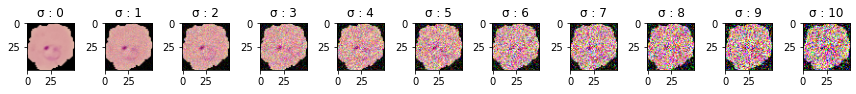

In [13]:
plt.figure(figsize = (12,12))
for i in range(len(noise_images)):
    plt.subplot(1, len(noise_images), i+1)
    img = noise_images[i]
    plt.imshow(img)
    plt.title('σ : ' + str(0+i))
    plt.tight_layout()
plt.show()

Text(0, 0.5, 'Accuracy')

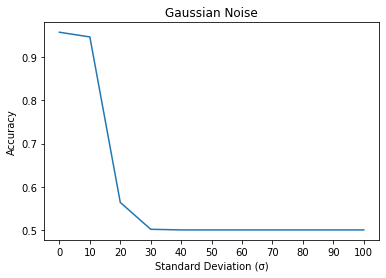

In [14]:
noise_list = []
for i in noise_dict:
    noise_list.append(i)
    
noise_list_values = []
for i in noise_dict.values():
    noise_list_values.append(i)

plt.plot(noise_list, noise_list_values)
plt.title('Gaussian Noise')
plt.xlabel("Standard Deviation (σ)")
plt.ylabel("Accuracy")

### CONTRAST

Inspired by https://stackoverflow.com/questions/59166448/whats-the-formula-used-in-pil-imageenhance-enhance-feature-for-color-brightnes

In [15]:
contrast_dict = {"0":test_predictions[1]}
contrast_images = [test_data[0]]

for i in np.arange(0.9, 0.0, -0.10):
    k=round(i, 2)

    path = r'data\test\Uninfected' # Source Folder
    dstpath_uninfected_contrast = r'Contrast\Uninfected' + "_blending_" + str(k) # Destination Folder

    try:
        makedirs(dstpath_uninfected_contrast)
    except:
        print("Directory already exist, images will be written in asme folder")

    # Folder won't used
    files = [f for f in listdir(path) if isfile(join(path,f))] 

    for image in files:
        try:
            src = cv2.imread(os.path.join(path,image), cv2.IMREAD_UNCHANGED)
            img = PIL.Image.fromarray(np.uint8(src))
            cn_enhancer = ImageEnhance.Contrast(img)
            mean = int(ImageStat.Stat(img.convert('L')).mean[0] + 0.5)
            cn_image_pre = Image.new('L', img.size, mean).convert(img.mode)
            cn_image = Image.blend(cn_image_pre, img, k)
            I = np.asarray(cn_image)
            dstPath = join(dstpath_uninfected_contrast,image)
            cv2.imwrite(dstPath, I) 
        except:
            print ("{} is not converted".format(image))
            
            
    path = r'data\test\Parasitized' # Source Folder
    dstpath_infected_contrast = r'Contrast\Parasitized' + "_blending_" + str(k) # Destination Folder

    try:
        makedirs(dstpath_infected_contrast)
    except:
        print("Directory already exist, images will be written in asme folder")

    # Folder won't used
    files = [f for f in listdir(path) if isfile(join(path,f))] 

    for image in files:
        try:
            src = cv2.imread(os.path.join(path,image), cv2.IMREAD_UNCHANGED)
            img = PIL.Image.fromarray(np.uint8(src))
            cn_enhancer = ImageEnhance.Contrast(img)
            mean = int(ImageStat.Stat(img.convert('L')).mean[0] + 0.5)
            cn_image_pre = Image.new('L', img.size, mean).convert(img.mode)
            cn_image = Image.blend(cn_image_pre, img, k)
            I = np.asarray(cn_image)
            dstPath = join(dstpath_infected_contrast,image)
            cv2.imwrite(dstPath, I) 
        except:
            print ("{} is not converted".format(image))
            
            
    contrast_parasitized_data = os.listdir(dstpath_infected_contrast)
    contrast_uninfected_data = os.listdir(dstpath_uninfected_contrast)
    
    
    contrast_test_data = []
    contrast_test_labels = []

    for img in contrast_parasitized_data:
        try:
            img_read = plt.imread('Contrast/Parasitized' + "_blending_" + str(k) + "/" + img)
            img_array = img_to_array(img_read)
            contrast_test_data.append(img_array)
            contrast_test_labels.append(1)
        except:
            None

    for img in contrast_uninfected_data:
        try:
            img_read = plt.imread('Contrast/Uninfected' + "_blending_" + str(k) + "/" + img)
            img_array = img_to_array(img_read)
            contrast_test_data.append(img_array)
            contrast_test_labels.append(0)
        except:
            None
            
            
    # test
    contrast_test_data = np.array(contrast_test_data)
    contrast_test_labels = np.array(contrast_test_labels)
    
    contrast_labels = np_utils.to_categorical(contrast_test_labels, num_classes = 2)
    
    #evaluate the model on test data
    contrast_predictions = saved_model.evaluate(contrast_test_data, contrast_labels)
    
    contrast_dict[str(k)] = contrast_predictions[1]
    
    contrast_images.append(contrast_test_data[0])

173/173 [==============================] - 4s 22ms/step - loss: 1.3237 - accuracy: 0.5000


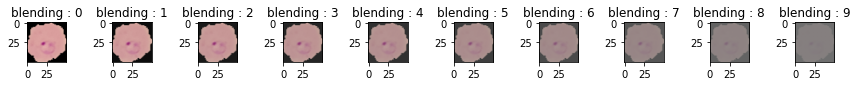

In [16]:
plt.figure(figsize = (12,12))
for i in range(len(contrast_images)):
    plt.subplot(1, len(contrast_images), i+1)
    img = contrast_images[i]
    plt.imshow(img)
    plt.title('blending : ' + str(0+i))
    plt.tight_layout()
plt.show()

Text(0, 0.5, 'Accuracy')

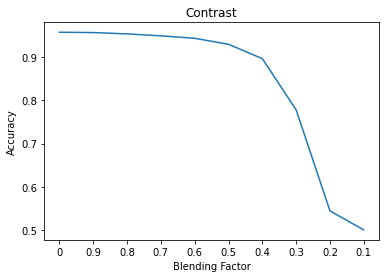

In [18]:
contrast_list = []
for i in contrast_dict:
    contrast_list.append(i)
    
contrast_list_values = []
for i in contrast_dict.values():
    contrast_list_values.append(i)

plt.plot(contrast_list, contrast_list_values)
plt.title('Contrast')
plt.xlabel("Blending Factor")
plt.ylabel("Accuracy")